<div align="center">
  <img src="../assets/logo.png" />
  <h1><b>2. GeoHawk CNN modeling and evaluation</b></h1>
  <small>Creating a convolutional neural network to predict the image latitude and longitude</small>
  <hr />
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

image_dir = 'data/img/'
df = pd.read_csv('data/image_data.csv')

# Dataset info
print(df.info())
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15627 entries, 0 to 15626
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state_name  15627 non-null  object 
 1   state_abbr  15627 non-null  object 
 2   latitude    15627 non-null  float64
 3   longitude   15627 non-null  float64
 4   filename    15627 non-null  object 
dtypes: float64(2), object(3)
memory usage: 610.6+ KB
None


,state_name,state_abbr,latitude,longitude,filename
2641,Connecticut,CT,41.499210,-72.608063,16705.png
8062,Texas,TX,31.933533,-94.299545,6715.png
1582,Idaho,ID,43.388371,-115.986717,12983.png
6935,Ohio,OH,39.802498,-83.848419,4046.png
4375,Oregon,OR,42.710667,-124.459412,12389.png


## **2.1 Preprocessing images**
Lets start with preprocessing all of the images to be of size 230x230. The network should still pick up on the most important features

In [2]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((320, 320))
    return np.array(image) / 255

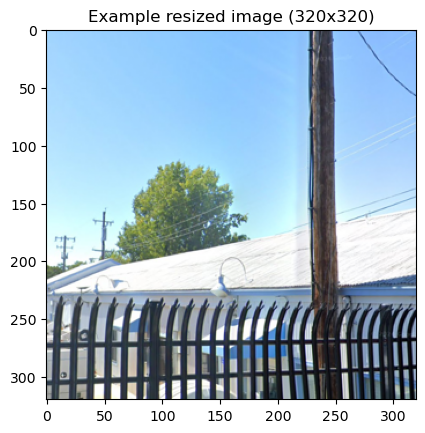

In [3]:
demo_img = load_and_preprocess_image(f'{image_dir}{df.sample(1).iloc[0]["filename"]}')

plt.imshow(demo_img)
plt.title('Example resized image (320x320)')
plt.show()

In [4]:
# Preprocess the data
X = df['filename'].map(lambda x: load_and_preprocess_image(f'{image_dir}{x}'))
X = np.stack(X.values)

# Prepare the labels for latitude and longitude
y_coords = df[['latitude', 'longitude']].values  # Ensure this is a 2D array

print(X.shape, y_coords.shape)

(15627, 320, 320, 3) (15627, 2)


## **2.2 Splitting the data**
Lets split the data into train (80%) and test (20%) subsets.

In [5]:
# Split the data into training and testing sets (80%, 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_coords_train, y_coords_test = train_test_split(
    X, y_coords, test_size=0.2, random_state=42)

print(f'Training set: {len(X_train)} samples')
print(f'Testing set: {len(X_test)} samples')

Training set: 12501 samples
Testing set: 3126 samples


## **2.3 Model design**
We have already stated that the model will be a Convolutional Neural Network (CNN). We will use the Keras library to build the model. I have also defined a custom loss function. This will calculate the distance between the actual location and the predicted location.

In [6]:
import tensorflow as tf

RADIUS_KM = 6378.1

def degrees_to_radians(deg):
    pi_on_180 = 0.017453292519943295
    return deg * pi_on_180

def loss_haversine(observation, prediction):    
    obv_rad = tf.map_fn(degrees_to_radians, observation)
    prev_rad = tf.map_fn(degrees_to_radians, prediction)

    dlon_dlat = obv_rad - prev_rad 
    v = dlon_dlat / 2
    v = tf.sin(v)
    v = v**2

    a = v[:,1] + tf.cos(obv_rad[:,1]) * tf.cos(prev_rad[:,1]) * v[:,0] 

    c = tf.sqrt(a)
    c = 2* tf.math.asin(c)
    c = c*RADIUS_KM
    final = tf.reduce_sum(c)

    #MAE with the haversine distance in KM
    final = final/tf.dtypes.cast(tf.shape(observation)[0], dtype= tf.float32)

    return final

2024-10-11 13:13:31.466124: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout

# Define the model
model = Sequential()

model.add(Conv2D(32, (7, 7), activation='relu', input_shape=(320, 320, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global average pooling instead of flattening to keep spatial information
model.add(GlobalAveragePooling2D())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Output layer for latitude and longitude (2 outputs)
model.add(Dense(2))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=loss_haversine,
              metrics=['mae']) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 314, 314, 32)      4736      
                                                                 
 batch_normalization (BatchN  (None, 314, 314, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 157, 157, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 153, 153, 64)      51264     
                                                                 
 batch_normalization_1 (Batc  (None, 153, 153, 64)     256       
 hNormalization)                                                 
                                                        

2024-10-11 13:13:33.536904: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor (e.g., 'val_loss' or 'val_mae')
    patience=10,              # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the weights of the best epoch after stopping
)

# Pass the callbacks to the fit function
history = model.fit(
    X_train, y_coords_train, 
    validation_data=(X_test, y_coords_test), 
    epochs=25,               # Set a high number of epochs to allow early stopping
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/25
391/391 [==============================] - 434s 1s/step - loss: 2400.5383 - mae: 20.0802 - val_loss: 1863.6030 - val_mae: 11.3161
Epoch 2/25
391/391 [==============================] - 414s 1s/step - loss: 1606.0082 - mae: 10.3054 - val_loss: 7008.5342 - val_mae: 41.9077
Epoch 3/25
391/391 [==============================] - 427s 1s/step - loss: 1521.7939 - mae: 9.8453 - val_loss: 3415.7310 - val_mae: 21.0404
Epoch 4/25
391/391 [==============================] - 426s 1s/step - loss: 1471.2126 - mae: 9.5105 - val_loss: 3460.4072 - val_mae: 22.3375
Epoch 5/25
391/391 [==============================] - 432s 1s/step - loss: 1445.6659 - mae: 9.3821 - val_loss: 2537.1111 - val_mae: 16.2230
Epoch 6/25
391/391 [==============================] - 426s 1s/step - loss: 1436.3481 - mae: 9.3307 - val_loss: 2051.6436 - val_mae: 12.4084
Epoch 7/25
391/391 [==============================] - 432s 1s/step - loss: 1427.7104 - mae: 9.2444 - val_loss: 1671.2687 - val_mae: 10.4246
Epoch 8/25
391/391

In [10]:
# Saving the model
model.save('USA/model/geohawk_usa_cnn_v2.h5')

## **2.4 Model evaluation**
We will evaluate the model using the custom loss function and the mean absolute error.

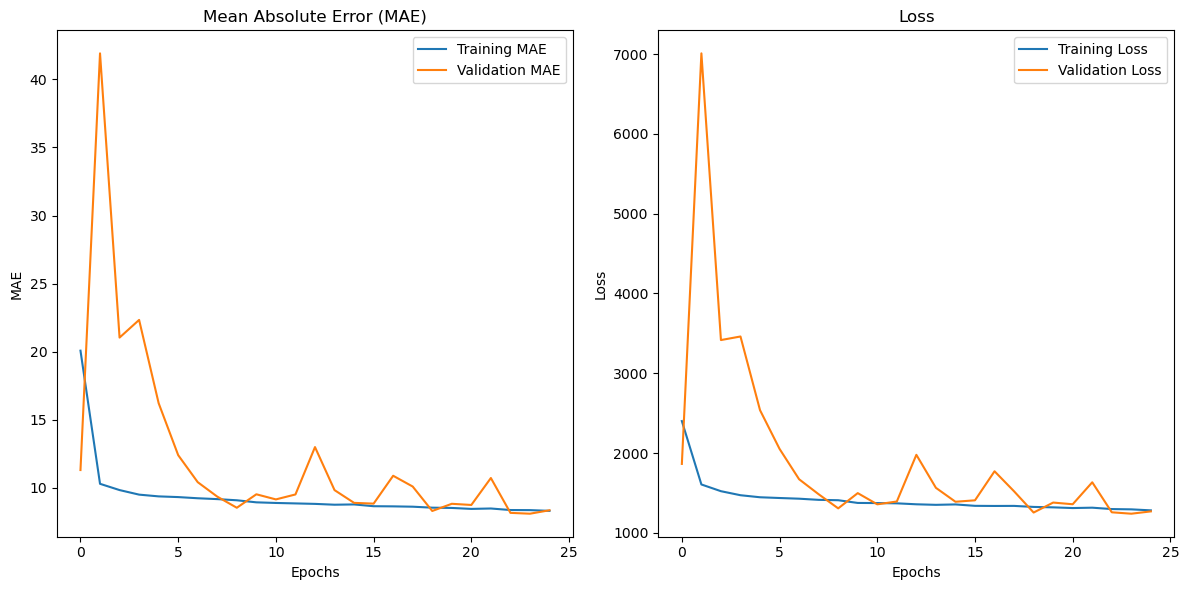

In [11]:
import matplotlib.pyplot as plt

# Access training history
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot MAE
plt.figure(figsize=(12, 6))

# Plot MAE
plt.subplot(1, 2, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()